---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

Graph 0
avg_shr_path: 4.099161161161161
avg_clustering: 0.03167539146454044


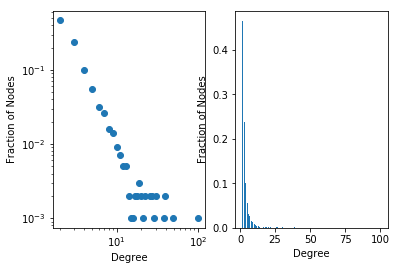

Graph 1
avg_shr_path: 5.089871871871872
avg_clustering: 0.5642419635919628


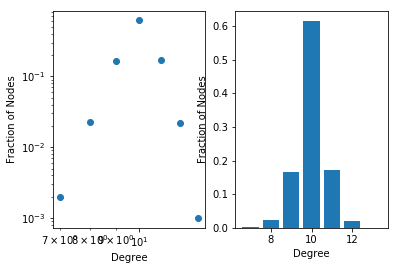

Graph 2
avg_shr_path: 9.378702269692925
avg_clustering: 0.4018222222222227


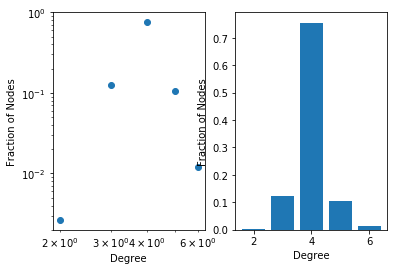

Graph 3
avg_shr_path: 3.1048046283934134
avg_clustering: 0.03780379975223251


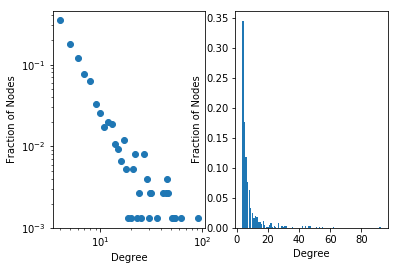

Graph 4
avg_shr_path: 5.0785509568313305
avg_clustering: 0.0033037037037037037


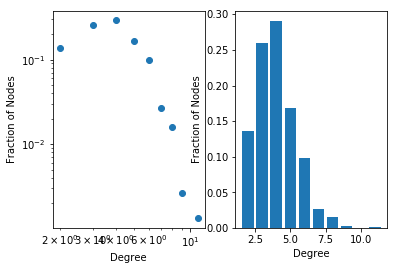

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, G in enumerate(P1_Graphs):
    print ('Graph {}'.format(i))
    print ('avg_shr_path: {}'.format(nx.average_shortest_path_length(G)))
    print ('avg_clustering: {}'.format(nx.average_clustering(G)))
    fig, axes = plt.subplots(1, 2)
    degrees = G.degree()
    degree_values = sorted(set(degrees.values()))
    histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]
    
    axes[0].plot(degree_values,histogram, 'o')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Fraction of Nodes')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    
    axes[1].bar(degree_values, histogram)
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Fraction of Nodes')
    plt.show()



In [3]:
def graph_identification():
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [4]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [5]:
def extract_features():
    df = pd.DataFrame(index=G.nodes())
    hubs,authorities = nx.hits(G)
    df['degree'] = pd.Series(G.degree())
    df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    df['clustering'] = pd.Series(nx.clustering(G))
    df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
    df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
    df['page_rank'] = pd.Series(nx.pagerank(G))
    df['hubs'] = pd.Series(hubs)
    df['authorities'] = pd.Series(authorities)
    df['management'] = pd.Series([node[1]['ManagementSalary'] for node in G.nodes(data=True)])
    return df
df = extract_features()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

def preprocess_data():
    test = df[~df['management'].isnull()]
    predict = df[df['management'].isnull()]

    features = df.columns[df.columns != 'management'].tolist()
    
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(test[features])
    y_train = test['management']
    X_predict = scaler.transform(predict[features])
    
    return X_train, y_train, X_predict, predict.index

In [7]:
def test_classifier(clf, data):
    X_train, y_train, _, _ = data
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)
    
    clf.fit(X_train, y_train)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    print('auc {}'.format(metrics.auc(fpr, tpr)))
    print('score {}'.format(clf.score(X_test, y_test)))

In [8]:
from sklearn.svm import SVC

def svc_model():  
    return SVC(C=1000, gamma='auto', kernel='rbf', probability=True)
test_classifier(svc_model(), preprocess_data())

auc 0.9142557651991614
score 0.8941798941798942


In [9]:
from sklearn.neural_network import MLPClassifier

def mlpc_model():
    return MLPClassifier(hidden_layer_sizes = [9, 4], alpha = 0.01, random_state = 0, solver='lbfgs', verbose=0)
test_classifier(mlpc_model(), preprocess_data())

auc 0.920335429769392
score 0.9312169312169312


In [10]:
def salary_predictions():
    X_train, y_train, X_predict, index = preprocess_data()
    
    clf = mlpc_model()
    
    clf.fit(X_train, y_train)
    
    predicted= clf.predict_proba(X_predict)[:,1]

    return pd.Series(predicted, index)
# salary_predictions()

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [11]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [12]:
def extract_features_2():
    def get_value_and_index(method, *args, **kwargs):
        result = list(method(G, *args, **kwargs))
        return pd.Series(data=[x for _, _, x in result], index=[(v,u) for v, u, _ in result])
    
    pref_att = get_value_and_index(nx.preferential_attachment)
    df = pd.DataFrame(index=pref_att.index)
    
    df['preferential_attachment'] = pref_att
    df['cn_soundarajan_hopcroft'] = get_value_and_index(nx.cn_soundarajan_hopcroft, community='Department')
    df['resource_allocation_index'] = get_value_and_index(nx.resource_allocation_index)
    df['jaccard_coefficient'] = get_value_and_index(nx.jaccard_coefficient)
    return df.fillna(value=0)
df2 = extract_features_2()
print(df2.shape)
df2.head()

(488446, 4)


,preferential_attachment,cn_soundarajan_hopcroft,resource_allocation_index,jaccard_coefficient
"(0, 2)",4180,6,0.055340,0.045802
"(0, 3)",3124,3,0.021388,0.027273
"(0, 4)",4224,3,0.021388,0.022222
"(0, 7)",3168,4,0.061668,0.036364
"(0, 8)",1628,1,0.011628,0.012821


In [13]:
def preprocess_data_2():
    df = future_connections.join(df2,how='outer')
    
    test = df[~df['Future Connection'].isnull()]
    predict = df[df['Future Connection'].isnull()]

    features = df.columns[df.columns != 'Future Connection'].tolist()
    
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(test[features])
    y_train = test['Future Connection']
    X_predict = scaler.transform(predict[features])
    
    return X_train, y_train, X_predict, predict.index

In [14]:
def mlpc_model_2():
    return MLPClassifier(hidden_layer_sizes = [9, 4], alpha = 0.01, random_state = 0, solver='lbfgs', verbose=0)
test_classifier(mlpc_model_2(), preprocess_data_2())

auc 0.9069339011623938
score 0.9616417714884696


In [15]:
def svc_model_2():  
    return SVC(C=1, gamma='auto', kernel='rbf', probability=True)
# test_classifier(svc_model_2(), preprocess_data_2())

In [16]:
def new_connections_predictions():
    X_train, y_train, X_predict, index = preprocess_data_2()
    
    clf = mlpc_model_2()
    
    clf.fit(X_train, y_train)
    
    predicted= clf.predict_proba(X_predict)[:,1]

    return pd.Series(predicted, index)
# new_connections_predictions()